### **Librairies**

In [1]:
import numpy as np
import cv2
import sys
import matplotlib.pyplot as plt
import skimage.io as io
import math
from PIL import Image
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
from skimage.exposure import histogram, cumulative_distribution
from skimage import img_as_ubyte, img_as_float
from scipy.stats import norm
from copy import deepcopy
import os
from os import listdir
import time
import pandas as pd
from scipy.cluster.vq import kmeans, vq
import seaborn as sns

### **Exemple d'image**

Type of the image :  <class 'numpy.ndarray'>
Shape of the image : (128, 128, 3)
Hight of the image 128
Width of the image 128
Dimension of the Image 3


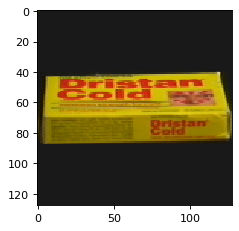

In [2]:
img = imread('archive/coil-100/coil-100/obj1__0.png')
plt.figure(num=None, figsize=(4, 3), dpi=80)
imshow(img)
#basic properties of image
print('Type of the image : ',type(img))
print('Shape of the image : {}'.format(img.shape))
print('Hight of the image {}'.format(img.shape[0]))
print('Width of the image {}'.format(img.shape[1]))
print('Dimension of the Image {}'.format(img.ndim)) 


We can see the shape of the image is three-layered and its width is 128, and the height of the image is 128. The type of image is an np array three-layered matrix.

### **Transformation de RGB à "Encoding Opponent"**

In [3]:
import cv2
import numpy as np

def read_image(file_image):
    img_array = cv2.imread(file_image)#open image
    return img_array

In [56]:
#opponent encoding
#rg = r - g
#by = 2*b -r - g
#wb = r + g + b
def opponent_encoding(img_array):
    np.seterr(over='ignore')
    img_array = np.int16(img_array)
    new_shape = [[[0 for k in range(3)] for j in range(img_array.shape[1])] for i in range(img_array.shape[0])]
    for i in range(len(img_array)):
        for j in range(len(img_array[i])):
            new_shape[i][j][0] = int(img_array[i][j][0] - img_array[i][j][1])
            new_shape[i][j][1] = int((2*img_array[i][j][2]) -img_array[i][j][0] - img_array[i][j][1])
            new_shape[i][j][2] = int(img_array[i][j][0] + img_array[i][j][1] + img_array[i][j][2])
    new_shape = np.array(new_shape)
    return new_shape

In [5]:
#normalization rg,by,wb
def normalization_array(new_shape):
    normalized = [[[0 for k in range(3)] for j in range(new_shape.shape[1])] for i in range(new_shape.shape[0])]
    for i in range(len(new_shape)):
        for j in range(len(new_shape[i])):
            normalized[i][j][0] = int(math.floor(((new_shape[i][j][0] + 255) / 510)*16))
            normalized[i][j][1] = int(math.floor(((new_shape[i][j][1] + 255) / 510)*16))
            normalized[i][j][2] = int(math.floor(((new_shape[i][j][2] + 255) / 510)*8))
    normalized = np.array(normalized)
    return normalized

### **Image après la transformation**

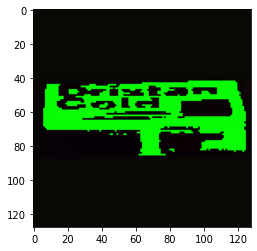

In [6]:
from matplotlib import pyplot as plt
img_array = read_image("archive/coil-100/coil-100/obj1__0.png")
img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
new_shape = opponent_encoding(img_array)
normalized = normalization_array(new_shape)
normalized = normalized.astype(np.uint8)
plt.imshow(normalized)
plt.show()

### **Mesures de similarité entre images (distance niveau de gris)**

In [7]:
def to_grayscale(arr):
    "If arr is a color image (3D array), convert it to grayscale (2D array)."
    if len(arr.shape) == 3:
        return np.average(arr, -1)  # average over the last axis (color channels)
    else:
        return arr

In [8]:
index_version1 = {}
images_version1 = {}

In [9]:
start_time = time.time()
folder_dir = "archive/coil-100/coil-100/"
j=1
for i in range(1,101):
    for j in range(0,356,5):
        imagename = folder_dir + "obj" + str(i) + "__" + str(j) + ".png"
        image = cv2.imread(imagename)
        index_img = "i" + str(i) + "__" + str(j)
        images_version1[index_img] = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        hist =  cv2.calcHist([image], [0], None, [256], [0, 256])
        hist = cv2.normalize(hist, hist).flatten()

        index_version1[index_img] = hist
print("--- %s seconds ---" % (time.time() - start_time))

--- 2.52537202835083 seconds ---


In [10]:
print(len(images_version1))

7200


In [11]:
def grayscale_distance(histA, histB,):
    d = np.sum([abs(a - b) for (a, b) in zip(histA, histB)])
    return d/256 #16777216 = nombre de cases

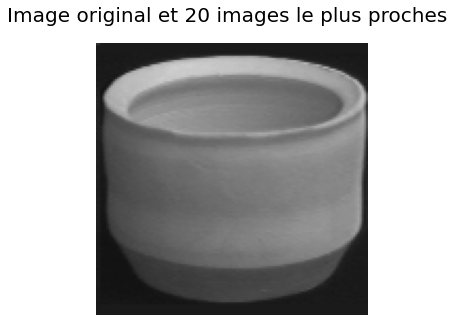

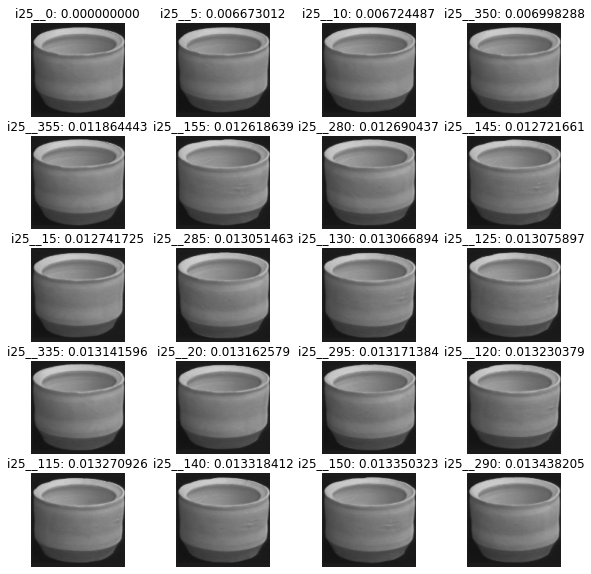

--- 0.9375741481781006 seconds ---


In [12]:
start_time = time.time()
results_version1 = {}
# results_version1loop over the index
for (k, hist) in index_version1.items():
    d = grayscale_distance(index_version1["i25__0"], hist)
    results_version1[k] = d

results_version1 = sorted([(v, k) for (k, v) in results_version1.items()])

fig=plt.figure(figsize=(5,5))
fig.suptitle("Image original et 20 images le plus proches",fontsize = 20)
ax = fig.add_subplot(1, 1, 1)
ax.imshow(cv2.cvtColor(images_version1["i25__0"],cv2.COLOR_GRAY2RGB))
plt.axis("off")

fig2=plt.figure(figsize=(10,10))

new = results_version1[0:20]
for (i, (v, k)) in enumerate(new):
    ax = fig2.add_subplot(5, 4, i + 1)
    ax.set_title("%s: %.9f" % (k, v))
    plt.imshow(cv2.cvtColor(images_version1[k],cv2.COLOR_GRAY2RGB))
    plt.axis("off")

plt.show()
print("--- %s seconds ---" % (time.time() - start_time))

### Taux d'erreur sur la base données 100 classes d'images

In [13]:
start_time = time.time()
list_correct = []
for elt in range(1,101):
    cpt = 0
    
    results_version1 = {}
    for (k, hist) in index_version1.items():
        name_image = "i"+ str(elt)+ "__0"
        d = grayscale_distance(index_version1[name_image], hist)
        results_version1[k] = d

    results_version1 = sorted([(v, k) for (k, v) in results_version1.items()])
    new = results_version1[0:20]
    for (i, (v, k)) in enumerate(new):
        name = "i"+ str(elt)
        if k.rpartition('__')[0] != name:
            cpt +=1
    list_correct.append(cpt)
print(f"Taux d'erreurs: {sum(list_correct)/100}%% \n")
print("--- %s seconds ---" % (time.time() - start_time))

Taux d'erreurs: 5.54%% 

--- 40.982280254364014 seconds ---


/tmp/ipykernel_276020/3507420591.py:12: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major', color='#666666', linestyle='-')


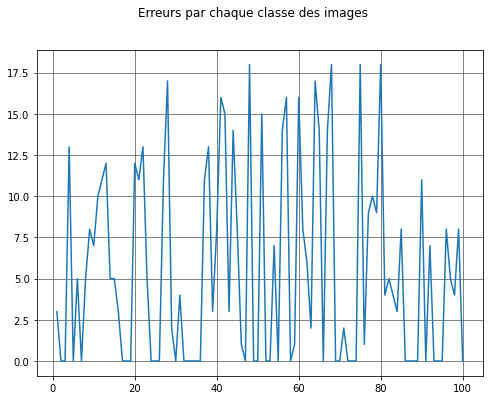

In [14]:
# The Data
x = list(range(1, 101))

# Create the figure and axes objects
fig, ax = plt.subplots(1, figsize=(8, 6))
fig.suptitle('Erreurs par chaque classe des images')

# Plot the data
ax.plot(x,list_correct)

# Show the grid lines as dark grey lines
plt.grid(b=True, which='major', color='#666666', linestyle='-')

plt.show()

### **Mesures de similarité entre images (avec la nouvelle représentation)**

In [15]:
index = {}
images = {}

In [16]:
start_time = time.time()
folder_dir = "archive/coil-100/coil-100/"
j=1
for i in range(1,101):
    for j in range(0,356,5):
        imagename = folder_dir + "obj" + str(i) + "__" + str(j) + ".png"
        image = cv2.imread(imagename)
        index_img = "i" + str(i) + "__" + str(j)
        images[index_img] = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        new_shape = opponent_encoding(image)
        normalized = normalization_array(new_shape)


        normalized = normalized.astype(np.uint8)
        hist = cv2.calcHist([normalized], [0, 1, 2], None, [16, 16,8],
            [0, 16, 0, 16, 0, 8])

        hist = cv2.normalize(hist, hist).flatten()

        index[index_img] = hist

print("--- %s seconds ---" % (time.time() - start_time))
            

--- 1058.1979455947876 seconds ---


In [17]:
print(len(images))
        

7200


In [18]:
def image_distance(histA, histB,):
    d = np.sum([abs(a - b) for (a, b) in zip(histA, histB)])
    return d/2048 #2048 = nombre de cases

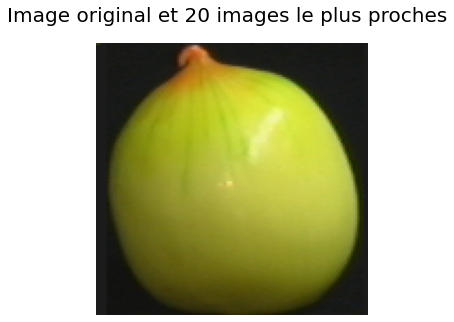

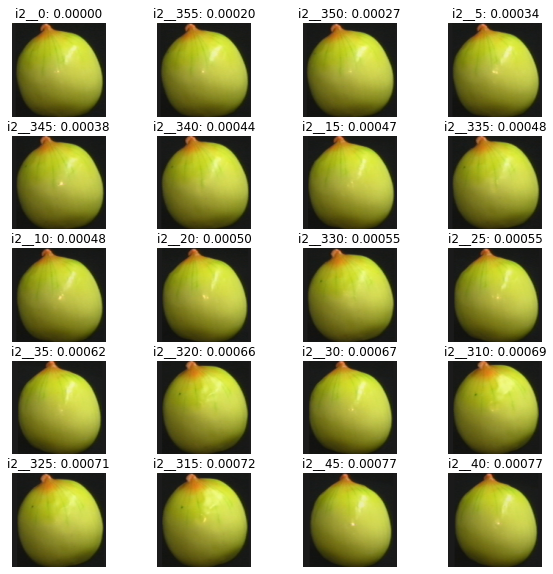

--- 3.237532138824463 seconds ---


In [19]:
start_time = time.time()
results = {}
# loop over the index
for (k, hist) in index.items():
    d = image_distance(index["i2__0"], hist)
    results[k] = d

results = sorted([(v, k) for (k, v) in results.items()])

fig=plt.figure(figsize=(5,5))
fig.suptitle("Image original et 20 images le plus proches",fontsize = 20)
ax = fig.add_subplot(1, 1, 1)
ax.imshow(images["i2__0"])
plt.axis("off")

fig2=plt.figure(figsize=(10,10))

new = results[0:20]
for (i, (v, k)) in enumerate(new):
    ax = fig2.add_subplot(5, 4, i + 1)
    ax.set_title("%s: %.5f" % (k, v))
    plt.imshow(images[k])
    plt.axis("off")

plt.show()

print("--- %s seconds ---" % (time.time() - start_time))

### Taux d'erreur sur la base données 100 classes d'images

In [20]:
start_time = time.time()
newlist_correct = []
for elt in range(1,101):
    cpt = 0
    
    results = {}
    for (k, hist) in index.items():
        name_image = "i"+ str(elt)+ "__0"
        d = grayscale_distance(index[name_image], hist)
        results[k] = d

    results = sorted([(v, k) for (k, v) in results.items()])
    new = results[0:20]
    for (i, (v, k)) in enumerate(new):
        name = "i"+ str(elt)
        if k.rpartition('__')[0] != name:
            cpt +=1
    newlist_correct.append(cpt)
print(f"Taux d'erreurs: {sum(newlist_correct)/100}%% \n")
print("--- %s seconds ---" % (time.time() - start_time))

Taux d'erreurs: 1.21%% 

--- 292.48506021499634 seconds ---


/tmp/ipykernel_276020/1139343955.py:12: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major', color='#666666', linestyle='-')


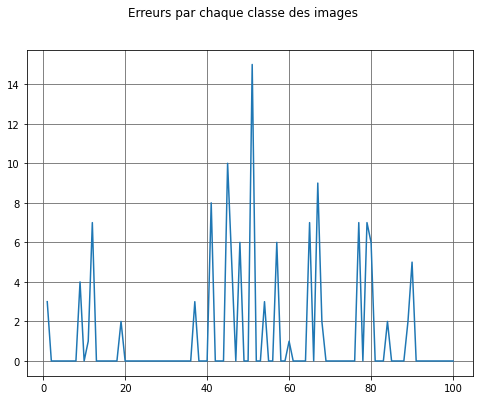

In [21]:
# The Data
x = list(range(1, 101))

# Create the figure and axes objects
fig, ax = plt.subplots(1, figsize=(8, 6))
fig.suptitle('Erreurs par chaque classe des images')

# Plot the data
ax.plot(x,newlist_correct)

# Show the grid lines as dark grey lines
plt.grid(b=True, which='major', color='#666666', linestyle='-')

plt.show()

### **Méthode Elbow pour déterminer le nombre de cluster**

### Méthode Elbow pour image en RGB

In [22]:
image =cv2.imread("archive/coil-100/coil-100/obj1__0.png")

In [23]:
r = []
g = []
b = []
for row in image:
    for pixel in row:
        # A pixel contains RGB values
        r.append(pixel[0])
        g.append(pixel[1])
        b.append(pixel[2])
df = pd.DataFrame({'red':r, 'green':g, 'blue':b})
df.head()

,red,green,blue
0,32,51,53
1,10,51,53
2,25,25,25
3,25,25,25
4,25,25,25


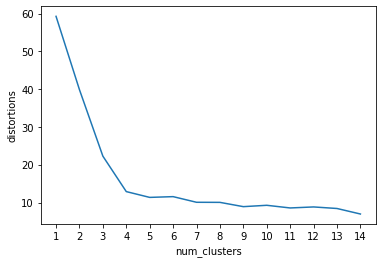

In [24]:
distortions = []
num_clusters = range(1, 15)
# Create a list of distortions from the kmeans function
for i in num_clusters:
    cluster_centers, distortion = kmeans(df[['red','green','blue']].values.astype(float), i)
    distortions.append(distortion)
# Create a data frame with two lists - num_clusters, distortions
elbow_plot = pd.DataFrame({'num_clusters': num_clusters, 'distortions': distortions})
# Creat a line plot of num_clusters and distortions
sns.lineplot(x='num_clusters', y='distortions', data = elbow_plot)
plt.xticks(num_clusters)
plt.show()

### Méthode Elbow pour image en RGB

In [60]:
image2 =cv2.imread("archive/coil-100/coil-100/obj1__0.png")
new_shape2 = opponent_encoding(image2)
normalized2 = normalization_array(new_shape2)
img2 = normalized2.astype(np.uint8)

In [61]:
rg = []
by = []
wb = []
for row in img:
    for pixel in row:
        # A pixel contains RGB values
        rg.append(pixel[0])
        by.append(pixel[1])
        wb.append(pixel[2])
df2 = pd.DataFrame({'rg':rg, 'by':by, 'wb':wb})
df2.head()

,rg,by,wb
0,53,51,32
1,53,51,10
2,25,25,25
3,25,25,25
4,25,25,25


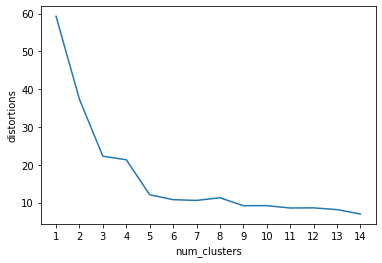

In [62]:
distortions2 = []
num_clusters2 = range(1, 15)

# Create a list of distortions from the kmeans function
for i in num_clusters2:
    cluster_centers2, distortion2 = kmeans(df2[['rg','by','wb']].values.astype(float), i)
    distortions2.append(distortion2)
# Create a data frame with two lists - num_clusters, distortions
elbow_plot = pd.DataFrame({'num_clusters': num_clusters2, 'distortions': distortions2})
# Creat a line plot of num_clusters and distortions
sns.lineplot(x='num_clusters', y='distortions', data = elbow_plot)
plt.xticks(num_clusters2)
plt.show()

Donc je choisis le nombre de cluster est à 5

### **Fonctions pour Segmentation**

In [63]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [64]:
def segmentoriginal(filename, k):

    #1. Load the image 
    img = cv2.imread(filename)
    
    h = img.shape[0]
    w = img.shape[1]
    
    img.shape = (img.shape[0] * img.shape[1], 3)
    
    kmeans = KMeans(n_clusters=k, random_state=0).fit(img).labels_
    kmeans.shape = (h, w)

    return kmeans

In [65]:
def newsegment(filename, k):

    img_array = cv2.imread(filename)
    new_shape = opponent_encoding(img_array)
    normalized = normalization_array(new_shape)
    img = normalized.astype(np.uint8)
    h = img.shape[0]
    w = img.shape[1]
    
    img.shape = (img.shape[0] * img.shape[1], 3)
    kmeans = KMeans(n_clusters=k, random_state=0).fit(img).labels_
    
    kmeans.shape = (h, w)

    return kmeans

In [66]:
import skimage
from sklearn.cluster import KMeans
from numpy import linalg as LA

def clustering(idx, filename, k):
    img = cv2.imread(filename)
    
    clusterValues = []
    for _ in range(0, k):
        clusterValues.append([])
    
    for r in range(0, idx.shape[0]):
        for c in range(0, idx.shape[1]):
            clusterValues[idx[r][c]].append(img[r][c])

    imgC = np.copy(img)

    clusterAverages = []
    for i in range(0, k):
#         print(len(clusterValues[i])/(idx.shape[1]*idx.shape[0]))
        clusterAverages.append(np.average(clusterValues[i], axis=0))
    
    for r in range(0, idx.shape[0]):
        for c in range(0, idx.shape[1]):
            imgC[r][c] = clusterAverages[idx[r][c]]
            
    return imgC

### **Segmentation image avec RGB coordonnées**

### Image avant de segmentation

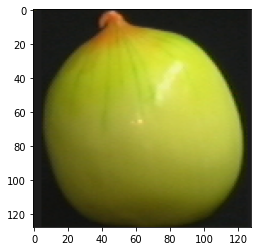

In [67]:
import cv2
import matplotlib.pyplot as plt 

def showimg(img):
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb)
showimg(cv2.imread("archive/coil-100/coil-100/obj2__0.png"))

### Image après de segmentation

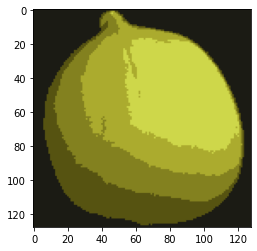

In [68]:
idx = segmentoriginal("archive/coil-100/coil-100/obj2__0.png", 5)
res = clustering(idx, "archive/coil-100/coil-100/obj2__0.png", 5)
showimg(res)

### **Segmentation image avec la nouvelle représentation**

### Image après de segmentation

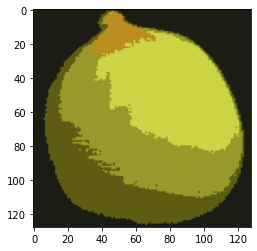

In [69]:
idx = newsegment("archive/coil-100/coil-100/obj2__0.png", 5)
res = clustering(idx, "archive/coil-100/coil-100/obj2__0.png", 5)
showimg(res)